In [1]:
import os
import sys
import json
import utils
import torch
import train
import shutil
import losses
import models
import numpy as np
from datetime import datetime

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
cfg_path = 'configs/unet.json'

In [6]:
with open(cfg_path, 'r') as file:
        cfg = json.load(file)

TRAIN_DIR = cfg['train_dir']
VAL_DIR = cfg['val_dir']
TRAIN_SIZE = cfg['train_size']
BATCH_SIZE = cfg['batch_size']
VAL_SIZE = cfg['val_size']
LOSS_STR = cfg['loss']
N_EPOCHS = cfg['n_epochs']
MODEL_STR = cfg['model']
OUTPUT_PATH = cfg['output_path']

if not os.path.exists(OUTPUT_PATH):
    raise ValueError('output path does not exist')

In [8]:
train_files = []
train_masks = []
for f in os.listdir(TRAIN_DIR):
    file = dict(np.load(os.path.join(TRAIN_DIR, f)))
    mask = file['cmask_map']
    mask[mask!=0] = 1
    file['cmask_map'] = mask
    train_files.append(file)
    train_masks.append(file['cmask_map'])
train_dataset = utils.segDataset(train_files, TRAIN_SIZE)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

val_files = []
for f in os.listdir(VAL_DIR):
    file = dict(np.load(os.path.join(VAL_DIR, f)))
    mask = file['cmask_map']
    mask[mask!=0] = 1
    file['cmask_map'] = mask
    val_files.append(file)
val_dataset = utils.segDataset_val(val_files, VAL_SIZE)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

Reading images...
Done!
Reading images...
Done!


In [9]:
import matplotlib.pyplot as plt

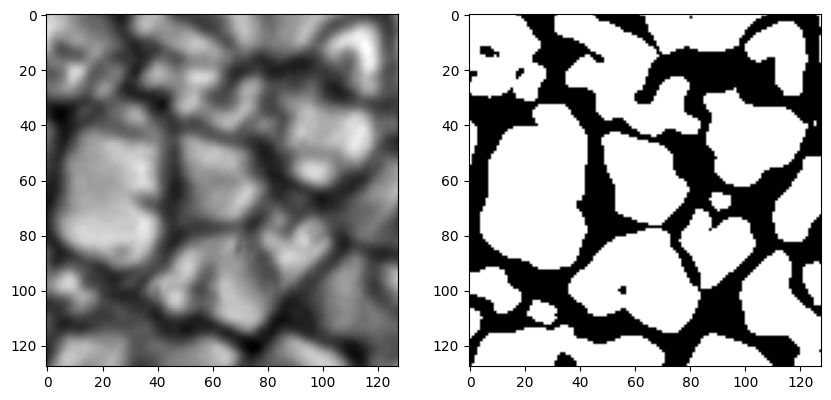

In [23]:
x, y = val_dataset[0]
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(x[0], cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(y, cmap='gray')

In [10]:
if MODEL_STR == 'unet':
    model = models.UNet()
else:
    raise ValueError('wrong model in config')

loss_weights = utils.get_weights(train_masks).to(device)

if LOSS_STR == 'focal':
    criterion = losses.FocalLoss(alpha=loss_weights).to(device)
elif LOSS_STR == 'lovazs':
    criterion = losses.Lovazs()
else:
    raise ValueError('wrong loss in config')

optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

experiment_dir_name = MODEL_STR + '_' + LOSS_STR + \
    '_' + datetime.now().strftime('%Y-%m-%d %H:%M:%S')
OUTPUT_PATH = os.path.join(
    OUTPUT_PATH, experiment_dir_name)

os.mkdir(OUTPUT_PATH)
shutil.copy2(cfg_path, OUTPUT_PATH)

'results/unet_focal_2024-05-23 15:36:31/unet_focal.json'

In [11]:
train.run(model=model, train_loader=train_loader, val_loader=val_loader, n_epochs=N_EPOCHS, criterion=criterion,
            optimizer=optimizer, device=device, output_path=OUTPUT_PATH, save_model=False, model_summary=True)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]             640
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
        DoubleConv-7         [-1, 64, 128, 128]               0
         MaxPool2d-8           [-1, 64, 64, 64]               0
            Conv2d-9          [-1, 128, 64, 64]          73,856
      BatchNorm2d-10          [-1, 128, 64, 64]             256
             ReLU-11          [-1, 128, 64, 64]               0
           Conv2d-12          [-1, 128, 64, 64]         147,584
      BatchNorm2d-13          [-1, 128, 64, 64]             256
             ReLU-14          [-1, 128,

KeyboardInterrupt: 